In [1]:
!nvidia-smi

Thu Aug 25 07:27:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:5E:00.0 Off |                    0 |
| N/A   45C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:D8:00.0 Off |                    0 |
| N/A   

In [2]:
import numpy as np
from tqdm.notebook import tqdm

In [3]:
import os
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

files = ['NLU-Evaluation-Data/AnnotatedData/NLU-Data-Home-Domain-Annotated-All.csv']
labels = []
sentences = []

for filename in files: 
    with open(filename, encoding='utf-8') as f:
        for line in f.readlines():
            line = line.split(';')
            if line[8]:
                sentences.append(line[8])
                labels.append(line[2] + '_' + line[3])

le = LabelEncoder()
ohe = OneHotEncoder()
ohe.fit(le.fit_transform(labels).reshape(-1, 1))

labels = np.array(labels)
sentences = np.array(sentences)
len(labels), len(sentences)

(20819, 20819)

# оставляем только 1 пример

In [4]:
labels = labels[367:368]
sentences = sentences[367:368]
labels, sentences

(array(['news_query'], dtype='<U24'),
 array(["what's sensational in time of india"], dtype='<U365'))

In [5]:
max_len = -1
lengths = []
for message in sentences:
    max_len = len(message.split()) if len(message.split()) > max_len else max_len
    lengths.append(len(message.split()))
max_len

6

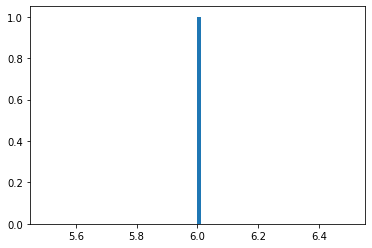

In [6]:
import matplotlib.pyplot as plt
plt.hist(lengths, bins=100)
plt.show()

In [7]:
TARGET_LEN = 52
EMBEDDING_SIZE = 200

# !!!ЭМБЕДИНГИ НЕ КАЧЕСТВЕННЫЕ, не сдавайся

In [8]:
import pickle
with open('word2vec_100.pkl', 'rb') as rf:
    W2V_100 = pickle.load(rf)
with open('fasttext_100.pkl', 'rb') as rf:
    FT_100 = pickle.load(rf)

In [9]:
norms = []
for token in W2V_100.wv.vocab:
    if np.linalg.norm(W2V_100.wv[token]) < 0.25:
        print(token)
    norms.append(np.linalg.norm(W2V_100.wv[token]))
min(norms)

neut
cyto
ijk


0.02994892

In [10]:
W2V_100.wv.most_similar(positive='please'), FT_100.wv.most_similar('me')

([('google', 0.5979539155960083),
  ('siri', 0.5428193211555481),
  ('wanna', 0.5294137597084045),
  ('hey', 0.5242522954940796),
  ('gotta', 0.5072860717773438),
  ('yourself', 0.49988099932670593),
  ('dialog', 0.48816388845443726),
  ('reschedule', 0.4799187183380127),
  ('your', 0.4734569489955902),
  ("let's", 0.4709017276763916)],
 [('us', 0.7899342775344849),
  ('him', 0.7358139157295227),
  ('meowk', 0.7257457971572876),
  ('mekk3', 0.7218109369277954),
  ('jme', 0.7211407423019409),
  ('rème', 0.718085527420044),
  ('dáme', 0.716890275478363),
  ('dôme', 0.7083154320716858),
  ('jérôme', 0.7071205377578735),
  ('gme', 0.7071195244789124)])

In [12]:
!pip install keras-nlp --upgrade

  Using cached keras_nlp-0.3.0-py3-none-any.whl (142 kB)
  Using cached tensorflow_text-2.9.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.6 MB)
  Using cached tensorflow_hub-0.12.0-py2.py3-none-any.whl (108 kB)
  Using cached tensorflow-2.9.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511.7 MB)
     |████████████████████████████████| 511.7 MB 376 bytes/s  0:00:01
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
     |████████████████████████████████| 4.9 MB 464 kB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 730 kB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 872 kB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 926 kB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 602 kB/s eta 0:00:01
     |████████████████████████████████| 3.4

(3, 52, 200)


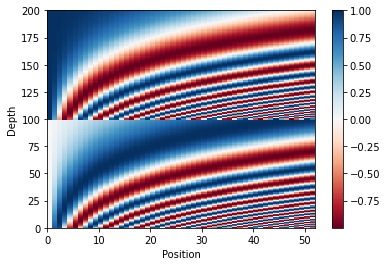

In [ ]:
from tqdm.notebook import tqdm
from gan_helpers import pad_sequences
def vectorize_sentence(sentence):
    vec = []
    for token in sentence.split():
        tkn_vec = np.concatenate((W2V_100.wv[token], FT_100.wv[token]), axis=0)
        vec.append(tkn_vec)
    return pad_sequences(vec, target_len=TARGET_LEN, embedding_size=EMBEDDING_SIZE)

In [36]:
RANDOM_DIM = 100


class DataGenerator():
    def __init__(self, labels, sentences, batches_per_epoch, batch_size):
        self.train_sentences = sentences
        self.train_labels = labels
        self.batches_per_epoch = batches_per_epoch
        self.batch_size = batch_size
    
    @staticmethod
    def rand_norm(npoints=1, ndim=RANDOM_DIM):
        rand_vec = np.random.normal(0, 1, size=[npoints, ndim])
        return rand_vec

    def __len__(self):
        return self.batches_per_epoch

    def batch(self):
        rand_sentences_indexes = np.random.randint(0, self.train_sentences.shape[0], size=self.batch_size)
        sent_batch = np.array([vectorize_sentence(sent) for sent in self.train_sentences[rand_sentences_indexes]])
        labels_batch = ohe.transform(le.transform(self.train_labels[rand_sentences_indexes]).reshape(-1, 1)).todense()
        return sent_batch, labels_batch

    def __iter__(self):
        for b in tqdm(range(self.batches_per_epoch), leave=False):
            yield self.batch()

    def rand_batch(self):
        rand_vec = self.rand_norm(self.batch_size)
        # for training generator with label
        rand_labels = np.random.randint(0, len(le.classes_), size=[self.batch_size])
        rand_labels = ohe.transform(rand_labels.reshape(-1, 1)).todense()
        return (rand_vec, rand_labels)


sample_size = 3
np.random.seed(42)
sent_indexes = np.random.randint(0, len(sentences), size=sample_size)
MESSAGES_FROM_DATASET = [sentences[sent_indexes], labels[sent_indexes]]
FIXED_NOISE = [DataGenerator.rand_norm(sample_size), ohe.transform(le.transform(labels[sent_indexes]).reshape(-1, 1)).todense()]
MESSAGES_FROM_DATASET

[array(["what's sensational in time of india",
        "what's sensational in time of india",
        "what's sensational in time of india"], dtype='<U365'),
 array(['news_query', 'news_query', 'news_query'], dtype='<U24')]

# GENERATOR

In [37]:
from gan_helpers import give_pe

In [38]:
from tensorflow import keras
from tensorflow.keras import backend as K
import numpy as np
from gan_helpers import make_generator


generator = make_generator(complexity=180, classes = len(le.classes_), verbose=False)
generated_from_noise = generator(FIXED_NOISE)
generated_from_noise.shape

TensorShape([3, 52, 200])

In [39]:
from scipy.spatial.distance import cosine


def distance_to_that_message(generated_vec):
    that_message_vec = vectorize_sentence(MESSAGES_FROM_DATASET[0][0])
    return np.mean([cosine(a, b)  for a, b in zip(generated_vec, that_message_vec)])


def message_recovery_with_metric(vector: np.ndarray):
    assert len(vector.shape) == 2
    tokens = []
    metric = []
    vector = vector.numpy()
    for token_vec in vector:
        w2v = token_vec[:100]
        if np.linalg.norm(w2v) < 0.25:
            token = ''
        else:
            token = W2V_100.wv.most_similar([w2v])[0][0]
        tokens.append(token)
        
        metric.append(cosine(token_vec[100:], FT_100.wv[token]))
    return ' '.join(tokens[-40:]).strip(), np.mean(metric), distance_to_that_message(vector)



for example in generated_from_noise:
    print(message_recovery_with_metric(example))

('defies withdrawing withdrawal withdrawal owing owing owing gaffe makes withdrawal withdrawal hus hus ameliorate materiality materiality nonessential nonessential nonessential preserving boggling boggling boggling menial importance objectivity neglecting neglecting neglecting neglecting neglecting neglecting neglecting neglecting neglecting neglecting neglecting seizes adopts proffer', 1.0619219488983687, nan)
('defies withdrawing withdrawal withdrawal owing owing owing gaffe makes withdrawal withdrawal hus hus ameliorate materiality materiality nonessential nonessential nonessential preserving boggling boggling boggling menial importance objectivity neglecting neglecting neglecting neglecting neglecting neglecting neglecting neglecting neglecting neglecting neglecting seizes adopts proffer', 1.061956226514527, nan)
('defies withdrawing withdrawal withdrawal owing owing owing gaffe makes withdrawal withdrawal hus hus ameliorate materiality materiality nonessential nonessential nonesse

# DISCRIMINATOR

In [40]:
from gan_helpers import make_discriminator
discriminator = make_discriminator(complexity=480, classes=len(le.classes_), verbose=False)
discriminator(generated_from_noise)[0]

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.47638056],
       [0.47638997],
       [0.47635394]], dtype=float32)>

# BUILDING GAN

In [41]:
def optimizer():
    return keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

In [42]:
def make_gan(discriminator, generator):   
    noise = generator.inputs
    texts = generator(noise)
    real_vs_fake_and_label = discriminator(texts)
    gan = keras.models.Model(inputs=noise, outputs=real_vs_fake_and_label)
    # make discrimator not trainable before compile
    # because GAN training is training of generator
    discriminator.trainable = False  
    gan.compile(
        loss={
            'discriminator': 'binary_crossentropy',
            'discriminator_1': 'categorical_crossentropy',
        },
        loss_weights={'discriminator':1, 'discriminator_1': 0.01},
        optimizer=optimizer(),
        metrics={'discriminator':'acc'})
    discriminator.trainable = True
    gan.summary()
    return gan

gan = make_gan(discriminator, generator)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 61)]         0                                            
__________________________________________________________________________________________________
model_2 (Functional)            (None, 52, 200)      1651790     input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
discriminator (Functional)      [(None, 1), (None, 6 1504822     model_2[0][0]              

# save and load

In [43]:
def save_models():
    discriminator.save('models/discriminator')
    generator.save('models/generator')
    gan.save('models/gan')
# save_models()

In [44]:
def load_models():
    discriminator = keras.models.load_model('models/discriminator')
    generator = keras.models.load_model('models/generator')
    gan = keras.models.load_model('models/gan')
# load_models()

# final logic check

In [45]:
gan(FIXED_NOISE)[0]

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.47638056],
       [0.47638997],
       [0.47635394]], dtype=float32)>

In [46]:
discriminator(generator(FIXED_NOISE))[0]

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.47638056],
       [0.47638997],
       [0.47635394]], dtype=float32)>

In [47]:
import warnings
warnings.filterwarnings('ignore')

# train

In [48]:
import tensorflow as tf
generator_acc_follow = []
generator_accuracy_cumulative = 0.5
discriminator_accuracy_cumulative = 0.5
generator_epochs = 0
loss_cumulative = 1
BATCH_SIZE = 256
data = DataGenerator(labels, sentences, batches_per_epoch=30, batch_size=BATCH_SIZE)

for epoch in range(300):
    print()
    generated_from_noise = generator(FIXED_NOISE)
    if epoch % 1 == 0:
        for example in generated_from_noise:
            print(message_recovery_with_metric(example))
    if all(message_recovery_with_metric(example)[0] == sentences[0] for example in generated_from_noise):
        print(f'training_finished in {generator_epochs} epochs')
        break
    # save_models()

    for sent_batch, labels_batch in data:
        ##########################
        # discriminator training #
        ##########################
        noise = data.rand_batch()
        generated_texts = generator(noise)
        # X
        X = np.concatenate([sent_batch, generated_texts])
        # target valuest smoothing
        y_real = np.random.uniform(0.8, 1, size=[BATCH_SIZE])
        y_real = np.ones((BATCH_SIZE,))
        y_fake = np.random.uniform(0, 0.2, size=[BATCH_SIZE])
        y_fake = np.zeros((BATCH_SIZE,))
        # Y
        y_real_fake = np.concatenate([y_real, y_fake])
        y_labels = np.concatenate([labels_batch, np.zeros((BATCH_SIZE, len(le.classes_)))]) 
        
#         print(discriminator.train_on_batch(X, [y_real_fake, np.array(y_labels)]))
        discriminator.trainable = True
        loss, _, _, accuracy = discriminator.train_on_batch(X, [y_real_fake, np.array(y_labels)])
        # print('1', loss, accuracy, discriminator(sent_batch)[0])
        discriminator_accuracy_cumulative = 0.99 * discriminator_accuracy_cumulative + 0.01 * accuracy
        generator_accuracy_cumulative = 1 - discriminator_accuracy_cumulative
        
        ######################
        # generator training #
        ######################
        discriminator.trainable = False
        while True:
            noise = data.rand_batch()
            # target values
    #         y_real_fake = np.random.uniform(0.9, 1.0, size=[BATCH_SIZE])
            y_real_fake = np.ones((BATCH_SIZE,))

            # train GAN and save accuracy to array
    #         print(gan.train_on_batch(noise, [y_real_fake, noise[1]]))

            loss, _, _, accuracy = gan.train_on_batch(noise, [y_real_fake, noise[1]])
            generator_epochs += 1
            accuracy = tf.math.reduce_mean(gan(noise)[0])
            # print('3', loss, accuracy)

            generator_accuracy_cumulative = 0.99 * generator_accuracy_cumulative + 0.01 * accuracy
            discriminator_accuracy_cumulative = 1 - generator_accuracy_cumulative
            print( 
                round(float(loss), 2),
                round(float(generator_accuracy_cumulative), 2),
                round(float(discriminator_accuracy_cumulative), 2),
                end='   \r',
            )
            if generator_accuracy_cumulative > 0.5:
                break
#     print()
#     if epoch%10==0:
#         generated_from_noise = generator(FIXED_NOISE)
#         for example in generated_from_noise:
#             print(message_recovery_with_metric(example))
        


('defies withdrawing withdrawal withdrawal owing owing owing gaffe makes withdrawal withdrawal hus hus ameliorate materiality materiality nonessential nonessential nonessential preserving boggling boggling boggling menial importance objectivity neglecting neglecting neglecting neglecting neglecting neglecting neglecting neglecting neglecting neglecting neglecting seizes adopts proffer', 1.0619219491132894, nan)
('defies withdrawing withdrawal withdrawal owing owing owing gaffe makes withdrawal withdrawal hus hus ameliorate materiality materiality nonessential nonessential nonessential preserving boggling boggling boggling menial importance objectivity neglecting neglecting neglecting neglecting neglecting neglecting neglecting neglecting neglecting neglecting neglecting seizes adopts proffer', 1.061956227266749, nan)
('defies withdrawing withdrawal withdrawal owing owing owing gaffe makes withdrawal withdrawal hus hus ameliorate materiality materiality nonessential nonessential noness

  0%|          | 0/30 [00:00<?, ?it/s]

ResourceExhaustedError:  OOM when allocating tensor with shape[256,26,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_3/discriminator/dropout_14/dropout/random_uniform/RandomUniform (defined at <ipython-input-48-56139d85a6e8>:58) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__forward_train_function_207654403]

Function call stack:
train_function


training_finished in 2775 epochs - with 128 batch size, 1 sample size

expected: any death news in times of india

In [ ]:
discriminator.train_on_batch(X, [y_real_fake, np.array(y_labels)])
y_labels

In [ ]:
labels_batch, np.zeros((BATCH_SIZE, len(le.classes_)))

In [ ]:
float(loss)

In [ ]:
for sent, lbl in data:
    print(sent[0][0])
    print(sent[0][-1])
    break

In [ ]:
generated_from_noise = generator(FIXED_NOISE)
print(generated_from_noise[-1][0])
print(generated_from_noise[-1][-1])

In [ ]:
generated_from_noise = generator.forward(*FIXED_NOISE)
generated_from_noise[0][-1]